# Original data manipulation

In [1]:
import matplotlib.pyplot as plt
from pandas import DataFrame, read_hdf, read_csv

These are the original values extracted from the `.h5` file used in the DeepLearning in Finance article.

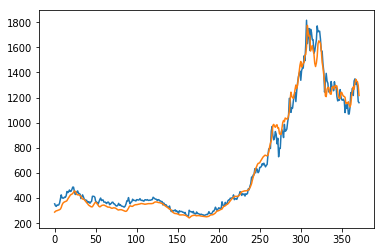

In [2]:
f = read_csv('../data/forecast_Gold_Inflation.csv')
plt.plot(range(len(f.test_y)), f.test_y)
plt.plot(range(len(f.forecast)), f.forecast)
plt.show()

This is the plot of the 14 values used to build the system

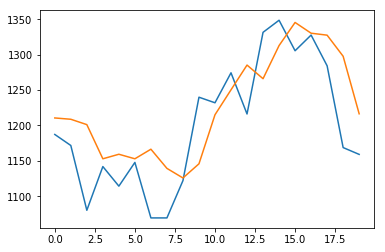

In [6]:
g = read_csv('../data/forecast20.csv')
plt.plot(range(len(g.test_y)), g.test_y)
plt.plot(range(len(g.forecast)), g.forecast)
plt.show()

Now I'm reading the original file to create a simple CSV file with the values I'm interested in.

In [37]:
h5 = DataFrame(read_hdf('DeepLearning.h5', 'Data_Gold'))
h5.head()

,Gold,DJI,InterestRate,Inflation,Reserves
DATE,,,,,
1985-02-01,304.80,1277.719971,8.50,106.3,37.251
1985-03-01,288.10,1299.359985,8.58,106.8,37.889
1985-04-01,324.65,1272.750000,8.27,107.0,37.661
1985-05-01,315.60,1242.050049,7.97,107.2,38.289
1985-06-01,313.15,1315.410034,7.53,107.5,39.386


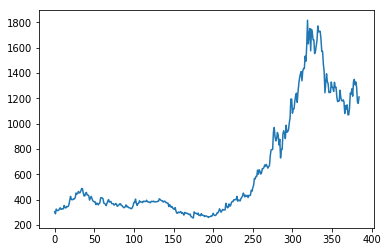

In [38]:
plt.plot(range(len(h5.Gold)), h5.Gold)
plt.show()

In [63]:
# Reshape date index and save it.

new_h5 = h5.reset_index().loc[:, ].rename(columns={'DATE': 'Date'})
new_h5.to_csv('Gold_data.csv', index=False)

In [ ]:
j = read_csv('Gold_data.csv')
plt.plot(range(len(j.Gold)),   j.Gold)
plt.show()

That's it. Now I've a simpler CSV file to play with in my code.

# Try the scaler

I'm having problems with the scaling, so I try the code isolated here, and re-inplant it back in the original code, once I'm sure everything is working fine.

In [87]:
from sklearn.preprocessing import StandardScaler

def scale_data(data: DataFrame) -> (DataFrame, StandardScaler):
    df = data.copy()
    sc = StandardScaler()
    df.loc[:, 'Gold'] = sc.fit_transform(
        df.loc[:, 'Gold'].values.reshape(-1, 1))
    return df, sc

def scale_back(data, custom_scaler):
    df = data.copy()
    df.loc[:, 'Gold'] = custom_scaler.inverse_transform(
        df.loc[:, 'Gold'].values.reshape(-1, 1))
    return df

In [91]:
j = read_csv('Gold_data.csv')
j.head()

,Date,Gold,DJI,InterestRate,Inflation,Reserves
0,1985-02-01,304.80,1277.719971,8.50,106.3,37.251
1,1985-03-01,288.10,1299.359985,8.58,106.8,37.889
2,1985-04-01,324.65,1272.750000,8.27,107.0,37.661
3,1985-05-01,315.60,1242.050049,7.97,107.2,38.289
4,1985-06-01,313.15,1315.410034,7.53,107.5,39.386


In [92]:
j_scaled, scaler = scale_data(j)
j_scaled.head()

,Date,Gold,DJI,InterestRate,Inflation,Reserves
0,1985-02-01,-0.769515,1277.719971,8.50,106.3,37.251
1,1985-03-01,-0.808540,1299.359985,8.58,106.8,37.889
2,1985-04-01,-0.723128,1272.750000,8.27,107.0,37.661
3,1985-05-01,-0.744276,1242.050049,7.97,107.2,38.289
4,1985-06-01,-0.750002,1315.410034,7.53,107.5,39.386


In [93]:
j_rescaled = scale_back(j_scaled, scaler)
j_rescaled.head()

,Date,Gold,DJI,InterestRate,Inflation,Reserves
0,1985-02-01,304.80,1277.719971,8.50,106.3,37.251
1,1985-03-01,288.10,1299.359985,8.58,106.8,37.889
2,1985-04-01,324.65,1272.750000,8.27,107.0,37.661
3,1985-05-01,315.60,1242.050049,7.97,107.2,38.289
4,1985-06-01,313.15,1315.410034,7.53,107.5,39.386


# View result

I copied the output from screen to a log file. The plot shows the evolution of the net value of my investment strategy. It MUST be improved by adding stop-loss signs.

In [8]:
log = read_csv('../data/log_sample.csv', sep='|')
log.head()

,t,price,forecast,budget,€.flow,value,net.Val,shares,action,reward,state
0,0,354.0,288.2,2200.0,0.0,0.0,0.0,0.0,buy,0.0,EVEN_DOWN_NOTHAVE_PRED_UNK
1,1,338.2,294.5,1846.0,-354.0,338.2,-15.8,1.0,buy,0.0,LOSE_DOWN_YESHAVE_PRED_UNK
2,2,333.7,298.5,1507.8,-692.2,667.4,-24.9,2.0,sell,-1.0,LOSE_DOWN_YESHAVE_PRED_OOK
3,3,345.6,299.9,1841.5,-358.6,345.6,-12.9,1.0,sell,-1.0,LOSE_DOWN_YESHAVE_PRED_NOK
4,4,343.4,302.9,2187.1,-12.9,0.0,-12.9,0.0,buy,0.0,LOSE_DOWN_NOTHAVE_PRED_OOK


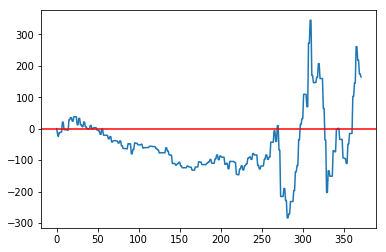

In [9]:
plt.plot(range(log.shape[0]), log.loc[:, 'net.Val'])
plt.axhline(y=0, c='red')
plt.show()

The RL trained for only 2500 iterations with 4 states: net value, forecast, got shares and last prediction result. Clearly, ir needs more time to train. If the simulation stops between 250 and 300, the result would have been a disaster.

# Experiments

I tried with 4 main sub-states:

  - Net value of my investment (EVEN, winning, loosing money)
  - Forecast: next value will be higer or lower
  - I do have shares or I do not have shares
  - Last forecast was unknown, right or wrong.
  
The result with this info on the full dataset or the reduced 20-entries sample is always positive, and the system seems to learn how to win (8.5%). 

However, if I remove the last state (last forecast) the trader reachs a positive result which is better than with 4 states (11.8% profit)

<img src="reward_3-states_20-entries.png">

Results (profit) from different combinations of the number of states and size of sample data:

|     | 3-states | 4-states | 5-states |
|-----|----------|----------|----------|
| 20  |   11.8   |   8.5    |  11.8    |
| 100 |          |          |  16.7    |
| 354 |          |          | -27.7    |

I don't manage to correctly set the rewards for stop loss situation. I also think that the coding is not OK.

    366 |  1348.8 |   1313.0 |    284.5 |  -1915.5 |   1348.8 |   -566.6 |    1.0 | none   | -100.0 | LOSE_DOWN_YESHAVE_PRED_NOK_STOPLOSS
    367 |  1305.7 |   1345.7 |    284.5 |  -1915.5 |   1305.7 |   -609.8 |    1.0 | sell   |   -1.0 | LOSE_GOUP_YESHAVE_PRED_OOK_STOPLOSS
    368 |  1327.9 |   1330.5 |   1590.2 |   -609.8 |      0.0 |   -609.8 |    0.0 | none   |   -1.0 | LOSE_GOUP_NOTHAVE_PRED_OOK_STOPLOSS

THe sell under stoploss should throw a +100 reward, however it only generates a -1.0.